## Improving the old MLP with good weight init

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open("../lines.txt", 'r').read().splitlines()
words = [wr.replace("/", "").replace("$", "") for wr in words]
words[:10]

["delicate savage  you'll never hold the cinder  but still you will burn ",
 'our destination  the skyline of this city  shining horizon ',
 'a splash and a cry   words pulled from the riverside   dried in the hot sun ',
 'hurt but poised for war  sturdy in crestfallen slumps  warrior spirit ',
 'steamy mist rising  rocks receiving downward crash  as the jungle weeps ',
 'a sultry wine night   spent with a beautiful girl   brash kiss ends smooth jazz ',
 'you were broken glass  but i touched you even though  i knew it would hurt ',
 'say not that i have  fled from the world but that the  world has fled from me ',
 'eyes dance with firelight  the moon and i are lovers  the spiteful sun dies ',
 'i woke up today  i wanted to write a song  i wrote a haiku ']

In [4]:
len(words)

11269

In [5]:
unwanted_chars = ['ß', 'à', 'ä', 'ç', 'è', 'é', 'ï', 'ñ', 'ó', 'ö', 'ü', 'ā']

def contains_unwanted_chars(word):
    return any(char in unwanted_chars for char in word)

filtered_haikus = [haiku for haiku in words if not any(contains_unwanted_chars(word) for word in haiku)]

In [6]:
words = filtered_haikus
len(words)

11235

In [7]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

In [8]:
stoi

{' ': 0,
 "'": 1,
 ',': 2,
 '.': 3,
 'a': 4,
 'b': 5,
 'c': 6,
 'd': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'h': 11,
 'i': 12,
 'j': 13,
 'k': 14,
 'l': 15,
 'm': 16,
 'n': 17,
 'o': 18,
 'p': 19,
 'q': 20,
 'r': 21,
 's': 22,
 't': 23,
 'u': 24,
 'v': 25,
 'w': 26,
 'x': 27,
 'y': 28,
 'z': 29}

In [9]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [3] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(f"'{''.join(itos[i] for i in context)}'", '---->', itos[ix])

            context = context[1:] + [ix]
    
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(43)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([637487, 3]) torch.Size([637487])
torch.Size([79514, 3]) torch.Size([79514])
torch.Size([79753, 3]) torch.Size([79753])


In [10]:
g = torch.Generator().manual_seed(213139812739)
C = torch.randn(len(chars), 10, generator=g)

W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)

W2 = torch.randn((200, len(chars)), generator=g) * 0.01
b2 = torch.randn(len(chars), generator=g) * 0
params = [C, W1, b1, W2, b2]

In [11]:
# print total parameters
sum(p.numel() for p in params)

12530

In [25]:
for param in params:
    param.requires_grad = True

In [26]:
max_steps = 200000
batch_size = 128 

lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    # forward pass
    emb = C[Xb]
    emb = emb.view(emb.shape[0], -1)
    pretanh = (emb @ W1 + b1)
    h = torch.tanh(pretanh)
    out = h @ W2 + b2

    loss = F.cross_entropy(out, Yb)

    # backward pass
    for p in params:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 100000 else 0.01

    for p in params:
        p.data -= lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item()}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.4144859313964844
  10000/ 200000: 1.9098647832870483
  20000/ 200000: 1.803507685661316
  30000/ 200000: 1.9733134508132935
  40000/ 200000: 1.7005343437194824
  50000/ 200000: 2.022634744644165
  60000/ 200000: 1.8622506856918335
  70000/ 200000: 1.7281441688537598
  80000/ 200000: 1.6634043455123901
  90000/ 200000: 1.6902517080307007
 100000/ 200000: 1.6961257457733154
 110000/ 200000: 1.7178378105163574
 120000/ 200000: 1.6769464015960693
 130000/ 200000: 1.8368576765060425
 140000/ 200000: 1.8164705038070679
 150000/ 200000: 1.7573423385620117
 160000/ 200000: 1.5369887351989746
 170000/ 200000: 2.267834424972534
 180000/ 200000: 1.5109503269195557
 190000/ 200000: 1.8515267372131348


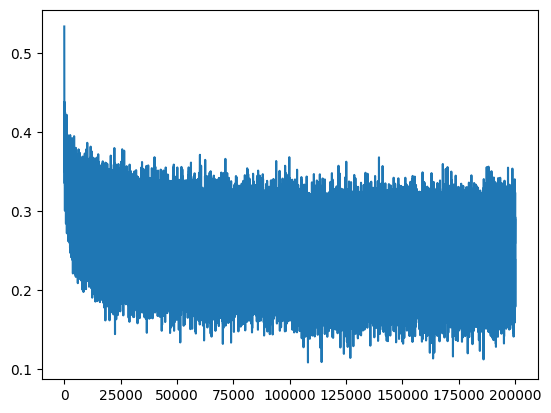

In [27]:
plt.plot(lossi)

In [28]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    emb = emb.view(emb.shape[0], -1)
    out = emb @ W1 + b1
    logits = F.tanh(out) @ W2 + b2
    loss = F.cross_entropy(logits, y)

    return loss.item()

split_loss('train'), split_loss('dev'), split_loss('test')

(1.7559022903442383, 1.7703694105148315, 1.785829782485962)

## Really good improvement

## Activation problems -> most values are 1 or -1

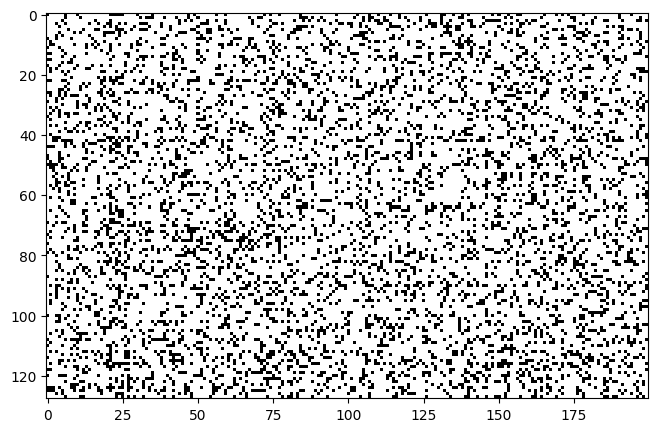

In [41]:
plt.figure(figsize=(10, 5))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

(array([10671.,   379.,   204.,   156.,   142.,   108.,    97.,    79.,
           71.,    78.,    50.,    52.,    50.,    59.,    55.,    54.,
           44.,    38.,    38.,    52.,    36.,    47.,    34.,    30.,
           38.,    45.,    41.,    35.,    31.,    34.,    47.,    39.,
           50.,    49.,    42.,    67.,    64.,    51.,    54.,    51.,
           80.,    81.,    77.,    93.,   120.,   127.,   147.,   225.,
          390., 10898.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

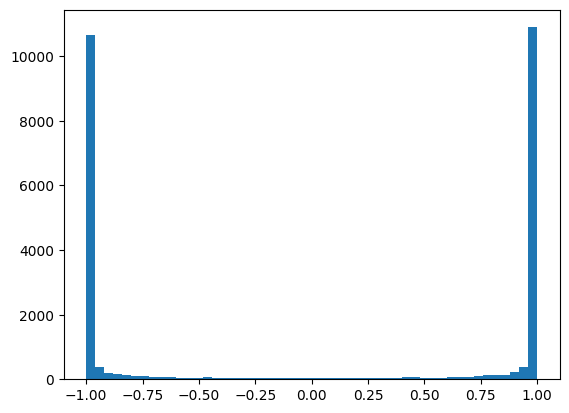

In [29]:
plt.hist(h.view(-1).tolist(), 50)

(array([1.000e+00, 0.000e+00, 2.000e+00, 5.000e+00, 2.000e+00, 1.400e+01,
        1.600e+01, 5.000e+01, 5.500e+01, 6.400e+01, 1.110e+02, 1.070e+02,
        1.860e+02, 2.560e+02, 3.370e+02, 4.240e+02, 5.760e+02, 7.280e+02,
        9.410e+02, 1.078e+03, 1.205e+03, 1.392e+03, 1.432e+03, 1.633e+03,
        1.684e+03, 1.647e+03, 1.687e+03, 1.585e+03, 1.515e+03, 1.274e+03,
        1.134e+03, 9.500e+02, 7.940e+02, 6.590e+02, 5.620e+02, 4.190e+02,
        3.240e+02, 2.090e+02, 1.800e+02, 1.120e+02, 9.700e+01, 6.500e+01,
        3.600e+01, 1.700e+01, 1.300e+01, 5.000e+00, 5.000e+00, 4.000e+00,
        2.000e+00, 6.000e+00]),
 array([-40.6934166 , -39.08099655, -37.46857651, -35.85615646,
        -34.24373642, -32.63131638, -31.01889633, -29.40647629,
        -27.79405624, -26.1816362 , -24.56921616, -22.95679611,
        -21.34437607, -19.73195602, -18.11953598, -16.50711594,
        -14.89469589, -13.28227585, -11.6698558 , -10.05743576,
         -8.44501572,  -6.83259567,  -5.22017563,  -3.60

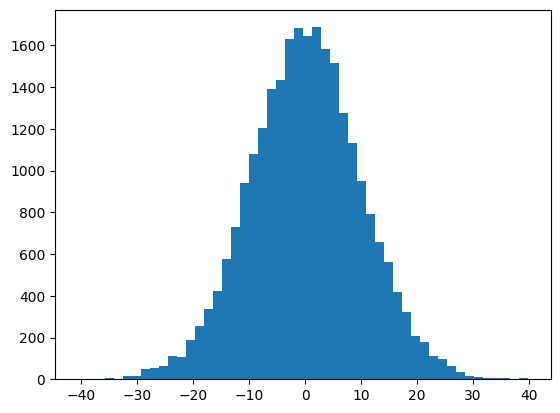

In [30]:
plt.hist(pretanh.view(-1).tolist(), 50)

### This can be fixed by scaling down weights

In [172]:
n_embd = 10
block_size = 3
neurons = 200

g = torch.Generator().manual_seed(213139812739)
C = torch.randn(len(chars), 10, generator=g)

# kaiming normal
W1 = torch.randn((n_embd * block_size, neurons), generator=g) * 5/3 / (n_embd * block_size) ** 0.5
b1 = torch.randn(neurons, generator=g) * 0.01
 
W2 = torch.randn((neurons, len(chars)), generator=g) * 0.01
b2 = torch.randn(len(chars), generator=g) * 0

bngain = torch.ones((1, neurons))
bnbias = torch.zeros((1, neurons))
bnmean_running = torch.zeros((1, neurons))
bnstd_running = torch.ones((1, neurons))

params = [C, W1, b1, W2, b2, bngain, bnbias]

In [173]:
Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([637487, 3]) torch.Size([637487])
torch.Size([79514, 3]) torch.Size([79514])
torch.Size([79753, 3]) torch.Size([79753])


In [174]:
for param in params:
    param.requires_grad = True

(array([ 34.,  98., 167., 216., 293., 366., 387., 427., 485., 490., 573.,
        620., 608., 619., 692., 654., 770., 685., 654., 753., 734., 676.,
        705., 713., 712., 817., 747., 765., 729., 714., 673., 677., 692.,
        660., 619., 611., 556., 573., 531., 489., 499., 431., 402., 365.,
        301., 243., 172., 110.,  67.,  26.]),
 array([-0.98391962, -0.94442671, -0.90493379, -0.86544088, -0.82594797,
        -0.78645505, -0.74696214, -0.70746923, -0.66797631, -0.6284834 ,
        -0.58899049, -0.54949757, -0.51000466, -0.47051175, -0.43101883,
        -0.39152592, -0.352033  , -0.31254009, -0.27304718, -0.23355426,
        -0.19406135, -0.15456844, -0.11507552, -0.07558261, -0.0360897 ,
         0.00340322,  0.04289613,  0.08238904,  0.12188196,  0.16137487,
         0.20086778,  0.2403607 ,  0.27985361,  0.31934652,  0.35883944,
         0.39833235,  0.43782526,  0.47731818,  0.51681109,  0.55630401,
         0.59579692,  0.63528983,  0.67478275,  0.71427566,  0.75376857,
 

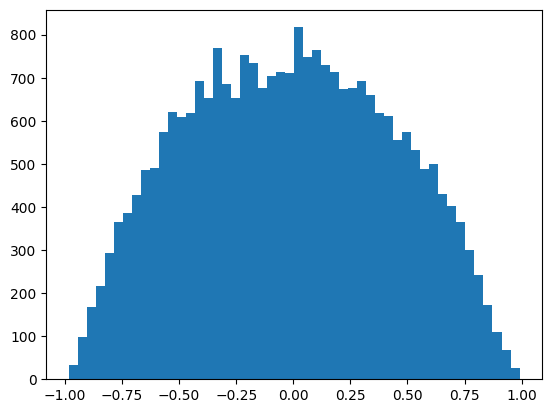

In [53]:
plt.hist(h.view(-1).tolist(), 50)

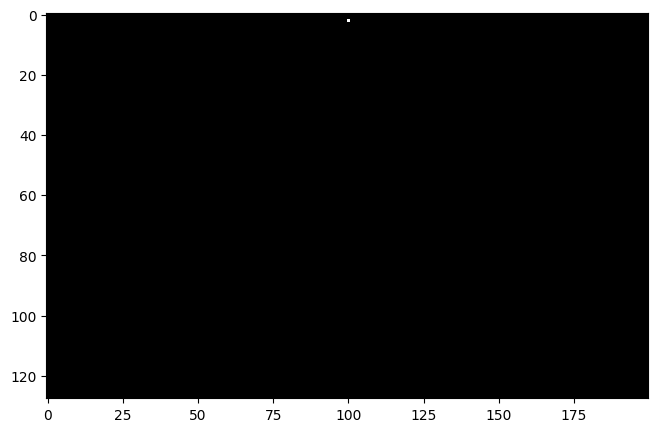

In [54]:
plt.figure(figsize=(10, 5))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

In [175]:
max_steps = 200000
batch_size = 32

lossi = []
log_lossi = []
eps = 1e-3

for i in range(max_steps):

    ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    # forward pass
    emb = C[Xb]
    emb = emb.view(emb.shape[0], -1)
    pretanh = (emb @ W1 + b1)

    # batch normalization
    mean = pretanh.mean(0, keepdim=True)
    std = pretanh.std(0, keepdim=True)
    pretanh = (pretanh - mean) / (std + eps)
    # shift and scale
    pretanh = pretanh * bngain + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * mean
        bnstd_running = 0.999 * bnstd_running + 0.001 * std

    h = torch.tanh(pretanh)
    out = h @ W2 + b2

    loss = F.cross_entropy(out, Yb)

    # backward pass
    for p in params:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 100000 else 0.01

    for p in params:
        p.data -= lr * p.grad

    if i % 10000 == 0 or i + 1 == max_steps:
        print(f'{i:7d}/{max_steps:7d}: {loss.item()}')

    lossi.append(loss.item())
    log_lossi.append(loss.log10().item())


      0/ 200000: 3.444597005844116
  10000/ 200000: 1.5908865928649902
  20000/ 200000: 1.9449756145477295
  30000/ 200000: 2.001439094543457
  40000/ 200000: 1.7461930513381958
  50000/ 200000: 1.7514716386795044
  60000/ 200000: 1.8520053625106812
  70000/ 200000: 1.8462045192718506
  80000/ 200000: 1.6732219457626343
  90000/ 200000: 2.0021770000457764
 100000/ 200000: 2.097975015640259
 110000/ 200000: 2.1307270526885986
 120000/ 200000: 2.043989658355713
 130000/ 200000: 1.441300630569458
 140000/ 200000: 1.725790023803711
 150000/ 200000: 1.9680384397506714
 160000/ 200000: 2.3110814094543457
 170000/ 200000: 1.8335788249969482
 180000/ 200000: 2.2168760299682617
 190000/ 200000: 1.8376322984695435
 199999/ 200000: 2.0261404514312744


In [176]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    emb = emb.view(emb.shape[0], -1)
    pretanh = (emb @ W1 + b1)
    pretanh = (pretanh - bnmean_running) / (bnstd_running + eps)
    # shift and scale
    pretanh = pretanh * bngain + bnbias
    h = torch.tanh(pretanh)
    out = h @ W2 + b2   
    loss = F.cross_entropy(out, y)

    return loss.item()

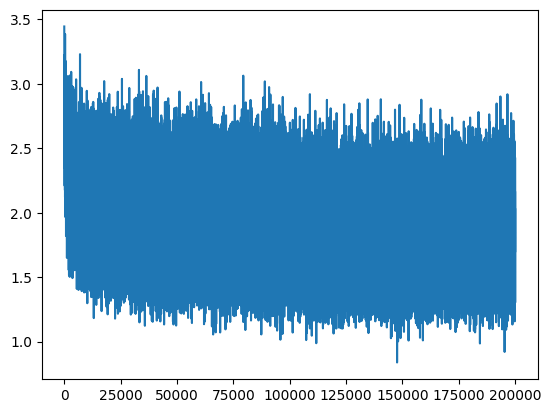

In [169]:
plt.plot(lossi)

### Improvement!!

### Pre weight init optimization -> (1.7559022903442383, 1.7703694105148315, 1.785829782485962)
### Post weight init optimization -> (1.7148950099945068, 1.729537844657898, 1.7452518939971924)
### Post Batch norm -> (1.77047860622406, 1.7761619091033936, 1.7911485433578491)

In [177]:
split_loss('train'), split_loss('dev'), split_loss('test')

(1.7705973386764526, 1.7762926816940308, 1.7913038730621338)

In [179]:
block_size = 3
for _ in range(20):
    res = []

    context = [3] * block_size
    while True:
        emb = C[torch.tensor(context)]
        emb = emb.view(1, -1)
        pretanh = (emb @ W1 + b1)
        pretanh = (pretanh - bnmean_running) / (bnstd_running + eps)
        pretanh = pretanh * bngain + bnbias
        h = torch.tanh(pretanh)
        out = h @ W2 + b2
        out = F.softmax(out, dim=1)
        out = torch.multinomial(out[0], 1).item()
        if out == 3:
            break
        context = context[1:] + [out]

        res.append(out)

    print(''.join(itos[i] for i in res).replace("  ", " "))
    print()

my like afting on all that it sun i go hill toshine wide i smell slicking the but and brang 

love 

ear word is sun sins colds of on in cold 

the eder samer firer's yeged to blanchone poean 

my hair and it of godtinn sumwelling always 

sing tired clearts i 

must hundertain therent be vame  drest i smill now a chold breame clashbove griend tone 

sione watch all good grinco nights all chank tiges a move  a swife the were from the me and exhelpemeding agains  mome no not ander light bus you was sight leave tring natain  to blast i cry reflecty blue's no mes hode tosess perfling in hear am heir  was  here 

i ted to your patting rains the mile celiness 

stone nowhy or fricall seekze to word they 

i leave cool a ver the have sucked to bothe red and nevellinessed in home 

easks solflyain a forghour shy fend to your splayresh at up 

on your trant is what to now 

one 

the the for again theys of my he won't ther the like morn 

beful feel 

wine woulderf cretempere day in my carreft